# Computing reaction ranges of spiral tips 
Tim Tyree<br>
3.19.2021

In [1]:
from lib.my_initialization import *
from lib import *
from lib.utils.merge_cloud_results import *
import seaborn as sns
# from scipy.interpolate import CubicSpline
from scipy.interpolate import splprep, splev
import matplotlib
%load_ext autoreload
%autoreload 2

In [3]:
# #make plots in darkmode
# import seaborn as sns
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# (ignore) don't make a nice snapshot

In [8]:
#load poster child csv
file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic018.21_traj_sr_600_mem_0.csv'
ic_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-out/ic018.21.npz'

In [10]:
txt=load_buffer(ic_fn)
# txt.shape
results_folder=f"{nb_dir}/Data/reaction-range-data"
if not os.path.exists(results_folder):
    os.mkdir(results_folder)
K_o=3.8
diffCoef=0.001
tmin_sec=0.1
#cython accelerated time integration of LR model
from lib.routines.generate_tip_logs_LR_model_cy import *
from lib.routines.kwargs_LR_model_cy import get_kwargs
kwargs = get_kwargs(ic_fn,results_folder=results_folder)
kwargs['tmax']=tmin_sec;print(tmin_sec)
kwargs['diffCoef']=diffCoef
kwargs['K_o']=K_o

0.1


In [12]:
dt=0.01
dsdpixel=0.025
width=200;height=200
printing=True
dt, one_step_map = get_one_step_map(nb_dir,dt=dt,width=width,height=height,**kwargs)
# dt, one_step_map = get_one_step_map(nb_dir,dt,**kwargs)
# dt, one_step_map = get_one_step_map(nb_dir,dt,dsdpixel,width,height,**kwargs)
# dt, one_step_map = get_one_step_map(nb_dir,dt,**kwargs)
txt_Istim_none=np.zeros(shape=(width,height), dtype=np.float64, order='C')
tmin_early_stopping=tmin_sec*10**3
t=0.
txt=load_buffer(ic_fn).astype('float64')
if printing:
    print(f"integrating to time t={tmin_early_stopping:.3f} ms without recording with dt={dt:.3f} ms.")
    print(f"long run times ~2 minutes expected...")
while (t<tmin_early_stopping):
    one_step_map(txt,txt_Istim_none)
    t+=dt
#precompute anything that needs precomputing
compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)


integrating to time t=100.000 ms without recording with dt=0.010 ms.
long run times ~30 minutes expected...


In [13]:
level1=-50.
level2=0.
#TODO: track trajectory up to some time at a high time resolution
#check for any tips being present
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
img=inVc[...,0]
dimgdt=dVcdt[...,0]
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)#,width=width,height=height)
n_tips=dict_out['n']#skip this trial if no spiral tips are present

In [14]:
txt_tmin_sec=txt.copy()
beep(4)

0

In [15]:
#verify whether the apparent tips agree with the recorded tips
df_recorded = pd.read_csv(file)

In [62]:
t

101.00000000001477

In [18]:
dict_out['x']


[39.43320793096633, 71.36478968000982, 113.368244624234, 137.53074058045675]

In [66]:
df_recorded[(df_recorded.t>=t-0.5)&(df_recorded.t<=t+0.5)]

,t,n,x,y,grad_ux,grad_uy,grad_vx,grad_vy,frame,particle
4,102.1,4,40.429343,92.236305,-1.998607,2.325863,1.009264,0.996001,1,0
5,102.1,4,72.733106,188.743225,1.391375,0.849711,-1.201806,1.850809,1,1
6,102.1,4,112.543357,171.457106,2.519008,0.000267,0.165827,1.544717,1,2
7,102.1,4,183.362633,133.380302,3.427614,-2.342126,-0.854130,3.554865,1,3


In [58]:
df_recorded

,t,n,x,y,grad_ux,grad_uy,grad_vx,grad_vy,frame,particle
0,100.1,4,40.548337,92.199403,-0.553877,1.689883,1.810026,0.649327,0,0
1,100.1,4,73.487393,188.108139,0.814119,1.071994,-0.940995,1.762460,0,1
2,100.1,4,112.437155,171.762151,1.498586,0.671171,-1.039589,2.331454,0,2
3,100.1,4,184.506626,134.780465,6.986454,-7.202513,-0.402078,2.923528,0,3
4,102.1,4,40.429343,92.236305,-1.998607,2.325863,1.009264,0.996001,1,0
...,...,...,...,...,...,...,...,...,...,...
11631,4342.1,2,187.891772,131.096488,30.292355,-40.981325,-3.480273,7.418969,2121,214
11632,4344.1,2,20.227102,139.203599,-0.122506,1.169241,0.212239,1.113146,2122,214
11633,4344.1,2,41.170893,130.110367,1.854642,0.729050,0.676319,1.101915,2122,208
11634,4346.1,2,27.120398,139.729592,0.017248,1.196949,0.393752,1.117110,2123,214


In [65]:
while (t<tmin_early_stopping+0.1*20):
    one_step_map(txt,txt_Istim_none)
    t+=dt

In [46]:
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
img=inVc[...,0]
dimgdt=dVcdt[...,0]
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)#,width=width,height=height)
n_tips=dict_out['n']#skip this trial if no spiral tips are present
dict_out['x']

[39.08073616356933, 71.21721473438139, 113.37730004476298, 137.45344901119302]

In [94]:
sorted(df_recorded[df_recorded.frame==15].x.values)
# list(df_recorded[(df_recorded.t>=t-0.5)&(df_recorded.t<=t+0.5)]['x'].values)

[25.92649282952212, 58.96848959088389, 137.7053651977637, 179.8717421132122]

In [68]:
dict_out['x']

[39.08073616356933, 71.21721473438139, 113.37730004476298, 137.45344901119302]

# DO analyze the existing spiral tip trajectory data

# plot naive reaction ranges at death and birth

## show birth/death range for LR model with dt=0.4ms

In [97]:
#load poster child csv
file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic018.21_traj_sr_600_mem_0.csv'
# ic_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-out/ic018.21.npz'
df=pd.read_csv(file)
df.head()

,t,n,x,y,grad_ux,grad_uy,grad_vx,grad_vy,frame,particle
0,100.1,4,40.548337,92.199403,-0.553877,1.689883,1.810026,0.649327,0,0
1,100.1,4,73.487393,188.108139,0.814119,1.071994,-0.940995,1.762460,0,1
2,100.1,4,112.437155,171.762151,1.498586,0.671171,-1.039589,2.331454,0,2
3,100.1,4,184.506626,134.780465,6.986454,-7.202513,-0.402078,2.923528,0,3
4,102.1,4,40.429343,92.236305,-1.998607,2.325863,1.009264,0.996001,1,0


In [2]:
def compute_DT(df,round_t_to_n_digits=3):
    '''DT is the time between two observations'''
    DT=np.around(df[(df.frame==1)].t.values[0]-df[(df.frame==0)].t.values[0],round_t_to_n_digits)
    return DT

In [99]:
#compute interactions
df_interactions=compute_df_interactions(file,DS=5./200.)
df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

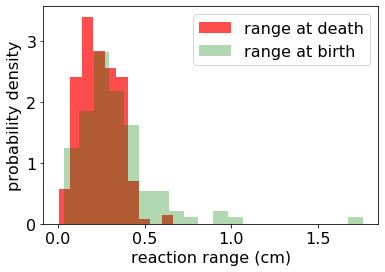

In [100]:
fontsize=16
#plot naive range at death and birth
plt.hist(DS*df_interactions.rT.values,bins=10,label='range at death',alpha=0.7,color='red',density=True)
plt.hist(DS*df_interactions.r0.values,bins=20,label='range at birth',alpha=0.3,color='green',density=True)
plt.ylabel('probability density',fontsize=fontsize)
plt.xlabel('reaction range (cm)',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.show()

In [101]:
print(f"for this trial,")
print(f"\tdeath range was {np.mean(death_ranges):.3f} +- {np.std(death_ranges):.3f} cm")
print(f"\tbirth range was {np.mean(birth_ranges):.3f} +- {np.std(birth_ranges):.3f} cm")
print(f"\ttime between two frames was {DT} ms")

for this trial,
	death range was 0.238 +- 0.116 cm
	birth range was 0.336 +- 0.233 cm
	time between two frames was 0.4 ms


^this is for the LR model

## show birth/death range for LR model with dt=?? ms

In [24]:
# file=f"{nb_dir}/Data/initial-conditions-suite-2/ds_5_param_set_8_V_0.5_fastkernel/ic_200x200.001.13_traj_sr_400_mem_0.csv"
# file=f"{nb_dir}/Data/initial-conditions-suite-1/ds_5_param_set_8/trajectories/ic_200x200.104.32_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_traj.csv"

#load poster child csv
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic018.21_traj_sr_600_mem_0.csv'
# ic_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-out/ic018.21.npz'
df=pd.read_csv(file)
df.head()

,t,x,y,s1,s2,n,V,f,s,frame,particle
0,0.1,199.117672,81.068080,"(0, 7)","(1, 10)",8,0.918039,0.169755,0.875708,0,0
1,0.1,23.842819,62.350583,"(1,)","(2,)",8,0.578522,0.044484,0.841978,0,1
2,0.1,1.996107,199.793501,"(1, 2, 9, 10)","(2, 5, 13, 15)",8,0.578522,0.044484,0.841978,0,2
3,0.1,66.059159,199.493540,"(3, 4)","(7, 8)",8,0.981046,0.118497,0.865600,0,3
4,0.1,74.396441,176.639687,"(4,)","(8,)",8,0.578522,0.044484,0.841978,0,4


In [25]:
def compute_DT(df,round_t_to_n_digits=3):
    '''DT is the time between two observations'''
    DT=np.around(df[(df.frame==1)].t.values[0]-df[(df.frame==0)].t.values[0],round_t_to_n_digits)
    return DT

In [28]:
DS=5./200.
DT=compute_DT(df,round_t_to_n_digits=3);print(DT)
#compute interactions
df_interactions=compute_df_interactions(file,DS=DS)
# df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

10.0


In [27]:
death_ranges.shape


(0,)

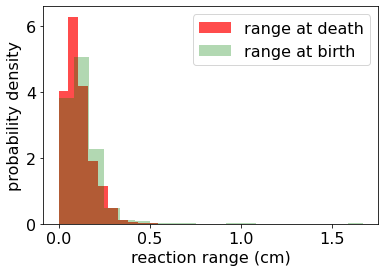

In [21]:
fontsize=16
#plot naive range at death and birth
plt.hist(DS*df_interactions.rT.values,bins=10,label='range at death',alpha=0.7,color='red',density=True)
plt.hist(DS*df_interactions.r0.values,bins=20,label='range at birth',alpha=0.3,color='green',density=True)
plt.ylabel('probability density',fontsize=fontsize)
plt.xlabel('reaction range (cm)',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.show()

print(f"for this trial,")
print(f"\tdeath range was {np.mean(death_ranges):.3f} +- {np.std(death_ranges):.3f} cm")
print(f"\tbirth range was {np.mean(birth_ranges):.3f} +- {np.std(birth_ranges):.3f} cm")
print(f"\ttime between two frames was {DT} ms")



for this trial,
	death range was 0.114 +- 0.077 cm
	birth range was 0.132 +- 0.104 cm
	time between two frames was 1.0 ms


## show birth/death range for FK model with dt=1.0 ms

In [256]:
from lib.routines.return_reaction_ranges_from_folder import *

In [ ]:
input_fn=search_for_file()
df=pd.read_csv(input_fn)
DT=compute_DT(df,round_t_to_n_digits=3);print(DT)

In [364]:
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_10_Ko_7/trajectories/ic001.21_traj_sr_400_mem_0.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_10_Ko_7/trajectories/ic010.12_traj_sr_400_mem_0.csv"
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/trajectories/ic004.33_traj_sr_600_mem_0.csv"
# input_fn=f"{nb_dir}/Data/initial-conditions-suite-2/ds_5_param_set_8_V_0.5_fastkernel/ic_200x200.001.13_traj_sr_400_mem_0.csv"


# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-300x300/ds_7.5_param_set_8/Log/ic300x300.0.6_traj_sr_600_mem_0.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-lr-300x300/param_qu_tmax_30/trajectories/ic300x300.3.3_traj_sr_600_mem_0.csv"
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-lr-600x600/param_qu_tmax_30/Log/ic600x600.0.1_traj_sr_1200_mem_0.csv"
width=200.
# df=pd.read_csv(input_fn)
# DT=compute_DT(df,round_t_to_n_digits=3);print(DT)
bin_edges=get_bin_edges(input_fn,ds=5.,width=width,nbins=100)

#TODO: use dask.bag on UB
input_fn_lst=[input_fn]
for input_fn in input_fn_lst:
    bin_count_death, bin_count_birth,DT=comp_bdrange_bincounts(input_fn,bin_edges,ds=5.,width=200.)

#TODO: reduce using dask.bag
# bin_count_death=sum_bin_count(bin_count_death1,bin_count_death2)
# bin_count_birth=sum_bin_count(bin_count_birth1,bin_count_birth2)

range_values,brate_values,drate_values=comp_bdrates_by_bin(bin_count_birth,bin_count_death,bin_edges,DT)
# TODO: put ^this in a routine that asks for a trajectory folder as input
# print(f"for this trial,")
# print(f"\tdeath range was {np.mean(death_ranges):.3f} +- {np.std(death_ranges):.3f} cm")
# print(f"\tbirth range was {np.mean(birth_ranges):.3f} +- {np.std(birth_ranges):.3f} cm")
# print(f"\ttime between two frames was {DT} ms")

In [365]:
beep(4)

0

In [366]:
# death_ranges,birth_ranges,DT=return_bd_ranges(input_fn,DS,round_t_to_n_digits=3)
DT=compute_DT(df,round_t_to_n_digits=3)
#compute interactions
df_interactions=compute_df_interactions(input_fn,DS=DS)
df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-lr-600x600/param_qu_tmax_30/Log/ic600x600.0.1_traj_sr_1200_mem_0.csv
death fit: (-0.3373994872096594, 0.18616306715070396, 0.1385657625455955)
birth fit: (-0.35300109194996043, 0.19738438220772428, 0.15183913572386426)


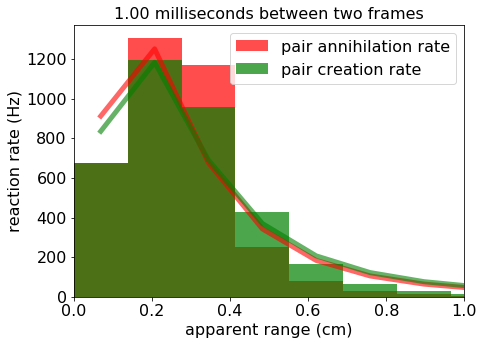

In [367]:
print(input_fn)
fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))

#for deaths
c,death_location,death_scale=genextreme.fit(death_ranges)
x=range_values
ax.plot(x, genextreme.pdf(x, c,loc=death_location,scale=death_scale)*500,
       'r-', lw=5, alpha=0.6, label='genextreme pdf')
ax.set_xlim([0,1])
print(f"death fit: {c,death_location,death_scale}")
#for births
cbirth,birth_location,birth_scale=genextreme.fit(birth_ranges)
ax.plot(x, genextreme.pdf(x, cbirth,loc=birth_location,scale=birth_scale)*500,
       'g-', lw=5, alpha=0.6, label='genextreme pdf')

print(f"birth fit: {cbirth,birth_location,birth_scale}")
plt.show()


(-0.8175525511646419, 0.017847279278342246, 0.021379449851870895)

In [ ]:
# def PlotRangesBD(bin_ranges,brate_values,drate_values,fontsize=16,figsize=(7,5)):
#     '''plots results of what was aggregated from a large number of tips'''
#     fig,ax=plt.subplots(figsize=figsize)
#     ax.bar(x=bin_ranges,height=drate_values,align='center',width=bin_width,alpha=0.7,color='red',label='pair annihilation rate')
#     ax.bar(x=bin_ranges,height=brate_values,align='center',width=bin_width,alpha=0.7,color='green',label='pair creation rate')
#     ax.set_xlabel('apparent range (cm)',fontsize=fontsize)
#     ax.set_ylabel('reaction rate (Hz)',fontsize=fontsize)
#     ax.legend(fontsize=fontsize)
#     ax.tick_params(axis='both', which='major', labelsize=fontsize)
#     ax.tick_params(axis='both', which='minor', labelsize=0)
#     ax.set_title(f"{DT_sec:.4f} seconds between two frames",fontsize=fontsize)
#     return fig,ax

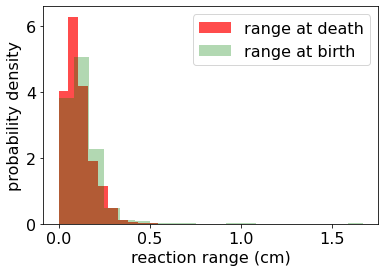

for this trial,
	death range was 0.114 +- 0.077 cm
	birth range was 0.132 +- 0.104 cm
	time between two frames was 1.0 ms


In [19]:
fontsize=16
#plot naive range at death and birth
plt.hist(death_ranges,bins=10,label='range at death',alpha=0.7,color='red',density=True)
plt.hist(birth_ranges,bins=20,label='range at birth',alpha=0.3,color='green',density=True)
plt.ylabel('probability density',fontsize=fontsize)
plt.xlabel('reaction range (cm)',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.show()
print(f"for this trial,")
print(f"\tdeath range was {np.mean(death_ranges):.3f} +- {np.std(death_ranges):.3f} cm")
print(f"\tbirth range was {np.mean(birth_ranges):.3f} +- {np.std(birth_ranges):.3f} cm")
print(f"\ttime between two frames was {DT} ms")

In [35]:
print(f"for this trial,")
print(f"\tdeath range was {np.mean(death_ranges):.3f} +- {np.std(death_ranges):.3f} cm")
print(f"\tbirth range was {np.mean(birth_ranges):.3f} +- {np.std(birth_ranges):.3f} cm")
print(f"\ttime between two frames was {DT} ms")


for this trial,
	death range was 0.114 +- 0.077 cm
	birth range was 0.132 +- 0.104 cm
	time between two frames was 1.0 ms


^this is for the FK model

# visualize the COM frame/trajectory versus time just before death
- TODO: compute annihilation speed near death in the COM frame
- TODO: plot ^that.  does an apparent range of acceleration/certain annihilation emerge?
- TODO: how often do spiral tips come closer than distance X and not promptly annihilate
- TODO: scatter plot of mean (stdev) interaction range, 
     - where each dot is 1 trial.  
     - xcoord = mean interaction range
     - ycoord = stdev interaction range
     - marker shape = type of trial

In [102]:
#select from the longest lived particles
index_longest=3
DT=compute_DT(df)
trajectory_lifetimes=DT*df.groupby('particle').count().sort_values(by='x',ascending=False).x
pid=int(trajectory_lifetimes.head(index_longest).index.values[-1])
pid

4

In [103]:
#identify the death partner of that particle
df_interactions[df_interactions.pid==pid]

,pid,pid_birthmate,pid_deathmate,r0,rT,Tavg,Tdiff
2,4,5,26,4.162882,6.048626,570.0,304.0


In [104]:
#compile distance metric
width=200;height=200;DS=0.025
distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)

In [105]:
n_frames=700#30

#compute the COM and the range between two spiral tips just before they annihilate
pid_other=df_interactions[df_interactions.pid==pid].pid_deathmate.values[-1]
d1=df[df.particle==pid].tail(n_frames).copy()
d1u=unwrap_traj_and_center(d1, width, height, DS)
d2=df[df.particle==pid_other].tail(n_frames).copy()
d2u=unwrap_traj_and_center(d2, width, height, DS)

In [106]:
#compute the shift between these two tips in their unwrapped coordinates
disp_1=(d1.head(1)-d1u.head(1))[['x','y']].values.flatten()
disp_2=(d2.head(1)-d2u.head(1))[['x','y']].values.flatten()

In [107]:
#compute individual particle speeds and truncate at final jump
x_values=d1u.x.values;y_values=d1u.y.values;t_values=d1u.t.values;
jump_lst,speed_lst=find_jumps_non_pbc(x_values,y_values,
    width,height,DS,DT,distance_L2_pbc=distance_L2_pbc,jump_thresh=30)
if len(list(jump_lst))>0:
    s1_values=np.array(speed_lst[jump_lst[-1]+1:])#*10**3 #cm per second
    t1_values=np.array(t_values[jump_lst[-1]+2:])-DT/2 #ms time before death
else:
    s1_values=np.array(speed_lst)#*10**3 #cm per second
    t1_values=np.array(t_values[1:]) #ms time before death
print(jump_lst)
#slice dataframe to include only those observations after any jumps
d1u=d1u[d1u.t>=t1_values[0]].copy()
d1=d1[d1.t>=t1_values[0]].copy()

#compute individual particle speeds and truncate at final jump
x_values=d2u.x.values;y_values=d2u.y.values;t_values=d2u.t.values;
jump_lst,speed_lst=find_jumps_non_pbc(x_values,y_values,
    width,height,DS,DT,distance_L2_pbc=distance_L2_pbc,jump_thresh=30)
if len(list(jump_lst))>0:
    s2_values=np.array(speed_lst[jump_lst[-1]+1:])#*10**3 #cm per second
    t2_values=np.array(t_values[jump_lst[-1]+2:]) #ms time before death
else:
    s2_values=np.array(speed_lst)#*10**3 #cm per second
    t2_values=np.array(t_values[1:])-DT/2 #ms time before death
print(jump_lst)

#slice dataframe to include only those observations after any jumps
d2u=d2u[d2u.t>=t2_values[0]].copy()
d2=d2[d2.t>=t2_values[0]].copy()

[291]
[]


In [108]:
#compute the COM and the range between two spiral tips just before they annihilate
xy_final_com=(d1.tail(1).values+d2.tail(1).values).flatten()[2:4]/2
xy_final_range=(d1.tail(1).values-d2.tail(1).values).flatten()[2:4]
final_range=np.linalg.norm(xy_final_range)*DS

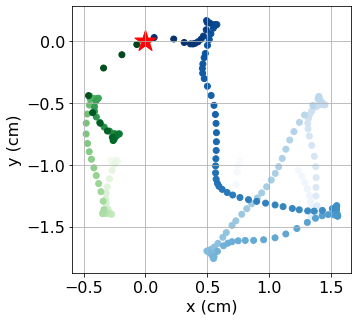

In [109]:
#plot that annihilation event in the transformed coordinates
x1_values=d1u.x.values-d1u.x.values[-1]+xy_final_range[0]/2
y1_values=d1u.y.values-d1u.y.values[-1]+xy_final_range[1]/2
c1_values=d1u.t.values
x2_values=d2u.x.values-d2u.x.values[-1]-xy_final_range[0]/2
y2_values=d2u.y.values-d2u.y.values[-1]-xy_final_range[1]/2
c2_values=d2u.t.values

#plot that annihilation event in the transformed death coordinates
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x1_values*DS,y1_values*DS,c=c1_values,cmap='Greens')
ax.scatter(x2_values*DS,y2_values*DS,c=c2_values,cmap='Blues')
ax.scatter([0],[0],c='red',marker='*',s=500)
# ax.scatter([xy_final_com[0]],[xy_final_com[1]],c='red',marker='*',s=500)
ax.set_ylabel('y (cm)',fontsize=fontsize)
ax.set_xlabel('x (cm)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.grid('on')
ax.set_aspect('equal')
plt.show()

In [110]:
lifetime_considered_1=x1_values.shape[0]*DT
lifetime_considered_2=x2_values.shape[0]*DT
print(f"lifetime considered for green was {lifetime_considered_1} ms.")
print(f"lifetime considered for blue was {lifetime_considered_2} ms.")

lifetime considered for green was 138.0 ms.
lifetime considered for blue was 310.0 ms.


In [111]:
#truncate both trajectories to briefest of the two
# tmin=np.min(np.hstack([t1_values,t2_values]))
tmin=np.max([np.min(t1_values),np.min(t2_values)])
boo1=tmin<=t1_values
boo2=tmin<=t2_values
x1_values=x1_values[boo1]
y1_values=y1_values[boo1]
c1_values=c1_values[boo1]
x2_values=x2_values[boo2]
y2_values=y2_values[boo2]
c2_values=c2_values[boo2]

In [112]:
#compute the range/displacement between the two spiral tips at each time point just before death
x=(x1_values+x2_values)/2
y=(y1_values+y2_values)/2
t_values=c1_values
#model ^that displacement time series using a Bezier curve
tck, u = splprep([x, y],u=t_values, s=0)
new_points = splev(u, tck,0)
#notice that (i) we force interpolation by using s=0, (ii) the parameterization, u, is generated automatically. Now plot the result:

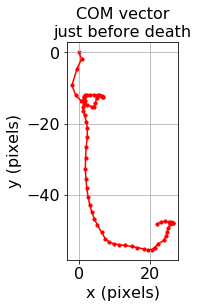

In [113]:
#plot COM just before death
fig, ax = plt.subplots()
ax.scatter(x, y,s=10,c='r')
ax.plot(new_points[0], new_points[1], 'r-')
ax.set_ylabel('y (pixels)',fontsize=fontsize)
ax.set_xlabel('x (pixels)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.grid('on')
ax.set_aspect('equal')
ax.set_title('COM vector\njust before death',fontsize=fontsize)
plt.show()

In [114]:
#compute the range/displacement between the two spiral tips at each time point just before death
delta_x_values=x1_values-x2_values
delta_y_values=y1_values-y2_values
x=delta_x_values
y=delta_y_values
t_values=c1_values
#model ^that displacement time series using a Bezier curve
tck, u = splprep([x, y],u=t_values, s=0)
new_points = splev(u, tck,0)#
#noice that (i) we force interpolation by using s=0, (ii) the parameterization, u, is generated automatically. Now plot the result:

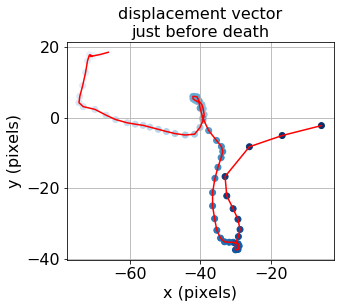

In [115]:
fig, ax = plt.subplots()
ax.scatter(x,y,c=c1_values,cmap='Blues')
ax.plot(new_points[0], new_points[1], 'r-')
ax.set_ylabel('y (pixels)',fontsize=fontsize)
ax.set_xlabel('x (pixels)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.grid('on')
ax.set_aspect('equal')
ax.set_title('displacement vector\njust before death',fontsize=fontsize)
plt.show()

In [116]:
#compute speed as the magnitude of the first derivative of ^that Bezier curve versus time
d_new_points_dt = splev(u, tck,1)
speed_values=np.linalg.norm(np.stack(d_new_points_dt),axis=0)*DS

In [117]:
# #checked that the first speed listed agrees the first speed resulting from the above
# dxdt_init=d_new_points_dt[0][0]
# dydt_init=d_new_points_dt[1][0]
# np.linalg.norm([dxdt_init,dydt_init])*DS

In [118]:
u_values=np.arange(np.min(u),np.max(u),.1)
d_new_points_dt = splev(u_values, tck,1)
speed_values=np.linalg.norm(np.stack(d_new_points_dt),axis=0)*DS*10**3

In [119]:
speed_values_naive=np.linalg.norm(np.diff(np.stack([delta_x_values,delta_y_values])),axis=0)*DS/DT*10**3

In [120]:
# #compute speed of each particle just before death
# dd1=d1u.diff()
# d1['speed']=(dd1.x**2+dd1.y**2)*DS/DT*10**3
# dd2=d2u.diff()
# d2['speed']=(dd2.x**2+dd2.y**2)*DS/DT*10**3

# s1_values=d1.dropna().speed.values
# s2_values=d2.dropna().speed.values
# t1_values=d1.dropna().t.values
# t2_values=d2.dropna().t.values

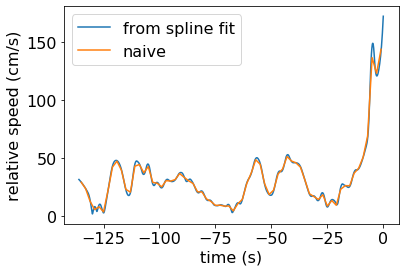

In [928]:
#plot relative speed just before death
tf=u_values[-1]
fig, ax = plt.subplots()
ax.plot(u_values-tf, speed_values,label='from spline fit')
ax.plot(c1_values[1:]-tf-DT/2, speed_values_naive,label='naive')
# #plot absolute speeds just before death
# plt.plot(t1_values-tf,s1_values,label='particle A')
# plt.plot(t2_values-tf,s2_values,label='particle B')

ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('relative speed (cm/s)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.legend(fontsize=fontsize)
# ax.set_title('COM vector\njust before death',fontsize=fontsize)
plt.show()

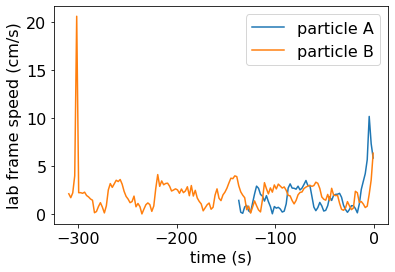

In [932]:
#plot relative speed just before death
#plot speeds for long time scales, and show whether they only react whenever speed crosses a thershold
tf=u_values[-1]
fig, ax = plt.subplots()
# ax.plot(u_values-tf, speed_values,label='from spline fit')
# ax.plot(c1_values[1:]-tf-DT/2, speed_values_naive,label='naive')
#plot absolute speeds just before death
plt.plot(t1_values-tf,s1_values,label='particle A')
plt.plot(t2_values-tf,s2_values,label='particle B')

ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('lab frame speed (cm/s)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.legend(fontsize=fontsize)
# ax.set_title('COM vector\njust before death',fontsize=fontsize)
plt.show()

In [947]:
#compute range versus time leading up to death
range_values=np.sqrt(delta_x_values**2+delta_y_values**2)*DS

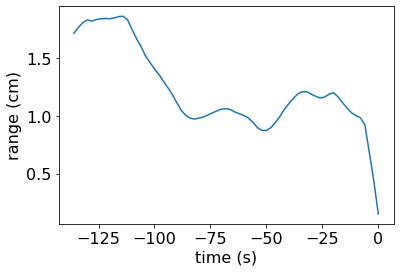

In [948]:
#plot relative range just before death
tf=u_values[-1]
fig, ax = plt.subplots()
# ax.plot(u_values-tf, range_values,label='from spline fit')
ax.plot(c1_values-tf, range_values,label='_Hidden')
# #plot absolute speeds just before death
# plt.plot(t1_values-tf,s1_values,label='particle A')
# plt.plot(t2_values-tf,s2_values,label='particle B')

ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('range (cm)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize)
# ax.set_title('COM vector\njust before death',fontsize=fontsize)
plt.show()

In [949]:
#TODO: plot relative speeds for several trajectories
#TODO: plot ensemble averaged relative speeds for many trials
#TODO: test whether tips only react when their relative range crosses a threshold
#TODO: decide what the (cleanest) measure of reaction will be


# Visualize timeseries data leading up to many deaths
- --> critical reaction range, $X>0$, appears to exist

In [121]:
def compute_death_timeseries(df,pid,pid_other,DT,n_frames_max=1000):
    #compute the COM and the range between two spiral tips just before they annihilate
    d1=df[df.particle==pid].tail(n_frames_max).copy()
    d1u=unwrap_traj_and_center(d1, width, height, DS)
    d2=df[df.particle==pid_other].tail(n_frames_max).copy()
    d2u=unwrap_traj_and_center(d2, width, height, DS)

    #compute the shift between these two tips in their unwrapped coordinates
    disp_1=(d1.head(1)-d1u.head(1))[['x','y']].values.flatten()
    disp_2=(d2.head(1)-d2u.head(1))[['x','y']].values.flatten()

    #compute individual particle speeds and truncate at final jump
    x_values=d1u.x.values;y_values=d1u.y.values;t_values=d1u.t.values;
    jump_lst,speed_lst=find_jumps_non_pbc(x_values,y_values,
        width,height,DS,DT,distance_L2_pbc=distance_L2_pbc,jump_thresh=30)
    if len(list(jump_lst))>0:
        s1_values=np.array(speed_lst[jump_lst[-1]+1:])#*10**3 #cm per second
        t1_values=np.array(t_values[jump_lst[-1]+2:])-DT/2 #ms time before death
    else:
        s1_values=np.array(speed_lst)#*10**3 #cm per second
        t1_values=np.array(t_values[1:]) #ms time before death
    # print(jump_lst)
    #slice dataframe to include only those observations after any jumps
    d1u=d1u[d1u.t>=t1_values[0]].copy()
    d1=d1[d1.t>=t1_values[0]].copy()

    #compute individual particle speeds and truncate at final jump
    x_values=d2u.x.values;y_values=d2u.y.values;t_values=d2u.t.values;
    jump_lst,speed_lst=find_jumps_non_pbc(x_values,y_values,
        width,height,DS,DT,distance_L2_pbc=distance_L2_pbc,jump_thresh=30)
    if len(list(jump_lst))>0:
        s2_values=np.array(speed_lst[jump_lst[-1]+1:])#*10**3 #cm per second
        t2_values=np.array(t_values[jump_lst[-1]+2:]) #ms time before death
    else:
        s2_values=np.array(speed_lst)#*10**3 #cm per second
        t2_values=np.array(t_values[1:])-DT/2 #ms time before death
    # print(jump_lst)

    #slice dataframe to include only those observations after any jumps
    d2u=d2u[d2u.t>=t2_values[0]].copy()
    d2=d2[d2.t>=t2_values[0]].copy()

    #compute the COM and the range between two spiral tips just before they annihilate
    xy_final_com=(d1.tail(1).values+d2.tail(1).values).flatten()[2:4]/2
    xy_final_range=(d1.tail(1).values-d2.tail(1).values).flatten()[2:4]
    final_range=np.linalg.norm(xy_final_range)*DS
    
    #compute the transformed coordinates
    x1_values=d1u.x.values-d1u.x.values[-1]+xy_final_range[0]/2
    y1_values=d1u.y.values-d1u.y.values[-1]+xy_final_range[1]/2
    c1_values=d1u.t.values
    x2_values=d2u.x.values-d2u.x.values[-1]-xy_final_range[0]/2
    y2_values=d2u.y.values-d2u.y.values[-1]-xy_final_range[1]/2
    c2_values=d2u.t.values

    #truncate both trajectories to briefest of the two
#     lifetime_considered_1=x1_values.shape[0]*DT
#     lifetime_considered_2=x2_values.shape[0]*DT
    tmin=np.max([np.min(t1_values),np.min(t2_values)])+DT/2
    boo1=tmin<c1_values
    boo2=tmin<c2_values
    x1_values=x1_values[boo1]
    y1_values=y1_values[boo1]
    c1_values=c1_values[boo1]
    x2_values=x2_values[boo2]
    y2_values=y2_values[boo2]
    c2_values=c2_values[boo2]

#     return tmin,c1_values,c2_values
    #compute the range/displacement between the two spiral tips at each time point just before death
    delta_x_values=x1_values-x2_values
    delta_y_values=y1_values-y2_values    
    
    #compute speed versus time leading up to death
    speed_values_naive=np.linalg.norm(np.diff(np.stack([delta_x_values,delta_y_values])),axis=0)*DS/DT*10**3
    speed_values = speed_values_naive[1:]+speed_values_naive[:-1] #simple moving average so t_values match

    #compute range versus time leading up to death
    range_values=np.sqrt(delta_x_values**2+delta_y_values**2)*DS
    range_values=range_values[2:]
    #compute times
    tf=c2_values[-1]
    range_t_values=c1_values-tf
    # speed_t_values=c1_values[1:]-tf-DT/2
    t_values=range_t_values[2:]

    #compute a DataFrame of all deaths with fields range and speed
    df_rxn=pd.DataFrame({
                't':t_values,
                 'range':range_values,
                 'speed':speed_values,
                'pid_self':pid+0*range_values.astype('int'),
                'pid_other':pid_other+0*range_values.astype('int')
                 })
    return df_rxn

In [122]:
# compute_death_timeseries(df,pid,pid_other,DT,n_frames_max=1000)
df=pd.read_csv(file)

In [123]:

for d in df_rxn_lst:
    print(d[0].shape[0],d[1].shape[0])

In [124]:
#select from the longest lived particles
df_rxn_lst=[]
DT=compute_DT(df)
trajectory_lifetimes=DT*df.groupby('particle').count().sort_values(by='x',ascending=False).x
for index_longest in range(50):#15):
    pid=int(trajectory_lifetimes.head(index_longest+1).index.values[-1])
    pid_other=df_interactions[df_interactions.pid==pid].pid_deathmate.values[-1]
    try:
        df_rxn=compute_death_timeseries(df,pid,pid_other,DT,n_frames_max=1000)
        df_rxn_lst.append(df_rxn)
    except AttributeError as e:
        print(e)
    except IndexError as e:
        print(e)

'NoneType' object has no attribute 'head'
'NoneType' object has no attribute 'head'
index -1 is out of bounds for axis 0 with size 0
'NoneType' object has no attribute 'head'
index -1 is out of bounds for axis 0 with size 0
index -1 is out of bounds for axis 0 with size 0
index -1 is out of bounds for axis 0 with size 0


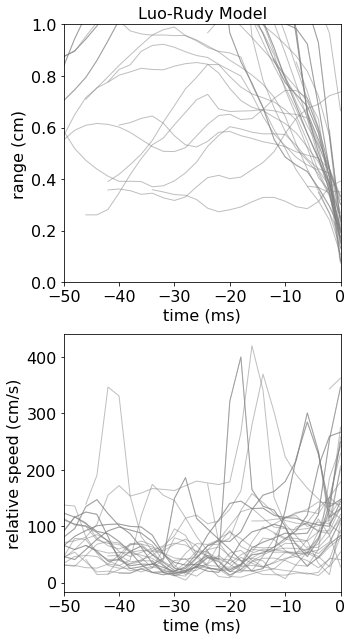

In [126]:
#TODO: plot relative speeds for several trajectories
#TODO: 2 panel plot of single df_rxn
fig, axs = plt.subplots(nrows=2,figsize=(5,9))

for df_rxn in df_rxn_lst:#[:-15]:
    #plot relative range just before death
    axs[0].plot(df_rxn['t'].values,df_rxn['range'].values,label="_Hidden",c='gray',lw=1,alpha=0.5)
    #plot relative speed just before death
    axs[1].plot(df_rxn['t'].values,df_rxn['speed'].values,label="_Hidden",c='gray',lw=1,alpha=0.5)


#format plots
ax=axs[0]
ax.set_xlabel('time (ms)',fontsize=fontsize)
ax.set_ylabel('range (cm)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_xlim([-50,0])
ax.set_ylim([0,1])
# ax.legend(fontsize=fontsize)

ax=axs[1]
ax.set_xlabel('time (ms)',fontsize=fontsize)
ax.set_ylabel('relative speed (cm/s)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_xlim([-50,0])

# ax.legend(fontsize=fontsize)
axs[0].set_title('Luo-Rudy Model', fontsize=fontsize)
plt.tight_layout()
plt.show()

In [1121]:
df[df.particle==pid_other]

,t,n,x,y,grad_ux,grad_uy,grad_vx,grad_vy,frame,particle
8705,3070.1,6,9.578241,32.519567,-0.778008,1.496666,-0.289696,1.395526,1485,167
8710,3072.1,10,6.558643,30.946317,-0.517594,1.296374,0.416603,1.132659,1486,167
8724,3074.1,10,1.862617,29.847463,0.007426,1.033248,0.693434,1.020607,1487,167
8733,3076.1,8,189.929986,40.828484,1.091951,0.574243,1.137328,0.357425,1488,167
8738,3078.1,8,187.177821,46.406722,1.130960,0.477036,1.233425,0.050091,1489,167
8744,3080.1,8,185.731014,50.119058,1.174812,0.364310,1.637508,-1.366832,1490,167
8755,3082.1,8,184.730220,54.017084,1.278564,0.064631,1.811436,-1.775615,1491,167


__Result__
- relative speed is not a clean measure for a rxn that is about to occur
- relative speed typically jumps for the last time within 2 ms of death
- at about t=-2 ms, annihilating tips are ~ 0.4 cm apart.
- range is a clean measure for a rxn that is about to occur within 5-50ms if tips come closer than X = 0.2-0.6 cm

# make measure for when the nearest tip comes closer than X=0.5 cm
- TODO: measure fraction of events that end in 

In [4]:
def compute_DT(df,round_t_to_n_digits=3):
    '''DT is the time between two observations'''
    DT=np.around(df[(df.frame==1)].t.values[0]-df[(df.frame==0)].t.values[0],round_t_to_n_digits)
    return DT

#measure the distance to the nearest tip for a given tip at a given frame
def compute_closest_range_lst(df,pid):
    d=df[df.particle==pid]
    frame_lst=list(set(d.frame.values))
    closest_range_lst=[]
    for frame in frame_lst:
        point_1=d[d.frame==frame][['x','y']].values.flatten()
        dist_lst=[]
        for point_2 in df[df.frame==frame][['x','y']].values:
            dist_lst.append ( distance_L2_pbc(point_1, point_2)*DS ) 
        closest_range=sorted(dist_lst)[1]
        closest_range_lst.append(closest_range)
    return frame_lst, closest_range_lst

In [5]:
def count_events_range_entered(df,pid,X):
    try:
        frame_lst, closest_range_lst = compute_closest_range_lst(df,pid)
        cr_values=np.array(closest_range_lst)
        t_values=DT*(np.array(frame_lst)-frame_lst[-1])
        boo=cr_values-X<0
        count=sum(boo[1:]&~boo[:-1])
        # frames_since_last_below_X=np.diff(np.argwhere(boo)).flatten()
        ends_closer_than_X = boo[-1]
    except Exception as e:
        print(e)
        ends_closer_than_X=False
        count=0
    return ends_closer_than_X, count

In [1244]:
#load poster child csv
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic018.21_traj_sr_600_mem_0.csv'
file=search_for_file()
#one fenton-karma trial
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffcoef_0.001/Log/ic200x200.0.0_traj_sr_400_mem_0.csv'
#another fenton-karma trial
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.0_traj_sr_400_mem_0.csv'
#LR
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/trajectories/ic001.13_traj_sr_600_mem_0.csv'
df=pd.read_csv(file)
df.head()

File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/trajectories/ic001.21_traj_sr_600_mem_0.csv


,t,n,x,y,grad_ux,grad_uy,grad_vx,grad_vy,frame,particle
0,100.1,10,30.732569,191.646518,-0.570121,1.253816,21.581881,-2.304258,0,0
1,100.1,10,63.721692,157.122933,2.767367,0.282536,0.178223,1.334809,0,1
2,100.1,10,86.917661,168.806645,-2.402777,2.752986,-16.404274,9.953692,0,2
3,100.1,10,87.337321,168.884275,-0.026232,1.534700,0.239563,1.391601,0,3
4,100.1,10,88.228863,168.849227,0.279641,1.380051,-0.640752,1.855520,0,4


In [1237]:
#count the fraction of events where range is entered
X_values=np.arange(0.1,1.0,0.1)
f_lst=[]
DT=compute_DT(df);print(DT)
#select from the longest lived particles
trajectory_lifetimes=DT*df.groupby('particle').count().sort_values(by='x',ascending=False).x
for X in X_values:
    count_lst=[]
    for index_longest in range(50):#15):
        pid=int(trajectory_lifetimes.head(index_longest+1).index.values[-1])
        ends_closer_than_X, count=count_events_range_entered(df,pid,X)
        if ends_closer_than_X:
            count_lst.append(count)
    #compute the fraction of events that come closer than range X and end with a range observed to be closer than X
    f = 1-sum(np.array(count_lst)>1)/len(count_lst)
    f_lst.append(f)
f_values=np.array(f_lst)
beep(10)

2.0


KeyboardInterrupt: 

In [1240]:
10*60/20*11

330.0

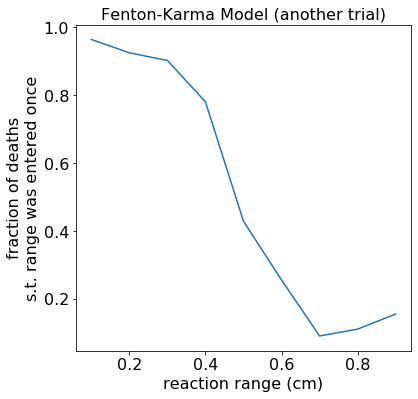

In [1233]:
fig,ax=plt.subplots(figsize=(6,5))
ax.plot(X_values,f_values)
ax.set_xlabel(r'reaction range (cm)',fontsize=fontsize)
ax.set_ylabel('fraction of deaths\ns.t. range was entered once',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize)
ax.set_title('Fenton-Karma Model (another trial)',fontsize=fontsize)
plt.show()

In [ ]:
#TODO: visualize a death event which has large range
#TODO: print long-ranged death versus time

## compute f versus X for all trials in folder
- iterate over all trials in a folder overnight

In [33]:
ntips=50
def compute_df_range(file):
    df=pd.read_csv(file)
    #count the fraction of events where range is entered
    X_values=np.arange(0.1,1.0,0.1)
    f_lst=[]
    DT=compute_DT(df);#print(DT)
    #select from the longest lived particles
    trajectory_lifetimes=DT*df.groupby('particle').count().sort_values(by='x',ascending=False).x
    for X in X_values:
        count_lst=[]
        for index_longest in range(ntips):#15):
            pid=int(trajectory_lifetimes.head(index_longest+1).index.values[-1])
            ends_closer_than_X, count=count_events_range_entered(df,pid,X)
            if ends_closer_than_X:
                count_lst.append(count)
        if len(count_lst)>0:
        #compute the fraction of events that come closer than range X and end with a range observed to be closer than X
            f = 1-sum(np.array(count_lst)>1)/len(count_lst)
        else:
            f = -9999
        f_lst.append(f)
    f_values=np.array(f_lst)
    df_range=pd.DataFrame({'src':os.path.basename(file),
         'f':f_values,'X':X_values})
    return df_range

def routine(file):
    return compute_df_range(file)

In [1329]:
#DONE: measure final range at time of death
#TODO: measure time since crossing X at time of death
file=search_for_file()

File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/trajectories/ic001.21_traj_sr_600_mem_0.csv


In [34]:
#FK
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.1_traj_sr_400_mem_0.csv'

#LR
file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic001.21_traj_sr_600_mem_0.csv'
input_fn_lst = get_all_files_matching_pattern(file,trgt='_mem_0.csv')
print(len(input_fn_lst))

157


In [30]:
retval=routine(file)

KeyboardInterrupt: 

In [35]:
df=pd.read_csv(file)
#count the fraction of events where range is entered
X_values=np.arange(0.1,1.0,0.1)
f_lst=[]
DT=compute_DT(df);#print(DT)

In [36]:
#compile distance metric
width=200;height=200;DS=0.025
distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)

In [37]:
# for fn in input_fn_lst:
#     #all CPU version
b = db.from_sequence(input_fn_lst, npartitions=9).map(routine)
start = time.time()
df_range_lst = list(b)
print(f"run time for generating birth-death rates from file_name_list: {time.time()-start:.2f} seconds.")
beep(10)

run time for generating birth-death rates from file_name_list: 3176.20 seconds.


0

In [38]:
#TODO: save df_range_lst as csv
df=pd.concat(df_range_lst)
# df.head()
favg_values=np.array([np.mean(df[(df.X==X)&(df.f>-1)].f.values) for X in X_values])
N_values=np.array([len(list(set(df[(df.X==X)&(df.f>-1)].src.values))) for X in X_values])
N_values

array([141, 154, 156, 157, 157, 157, 157, 157, 157])

In [39]:
folder=os.path.dirname(os.path.dirname(file))
os.chdir(folder)
savefn=f'rxn_range_results_ntips_{ntips}.csv'
df.to_csv(savefn,index=False)
print(os.path.abspath(savefn))

/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/rxn_range_results_ntips_50.csv


In [1328]:
#TODO: compute the average and standard deviation, averaging over src


'/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005'

In [129]:
#compute the average averaging over src
os.chdir('/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005')
df=pd.read_csv('rxn_range_results_ntips_1.csv')
favg_values=np.array([np.mean(df[(df.X==X)&(df.f>-1)].f.values) for X in X_values])
ferr_values=np.array([np.std(df[(df.X==X)&(df.f>-1)].f.values) for X in X_values])
N_values=np.array([len(list(set(df[(df.X==X)&(df.f>-1)].src.values))) for X in X_values])
N_values

array([191, 279, 288, 290, 292, 296, 299, 301, 304])

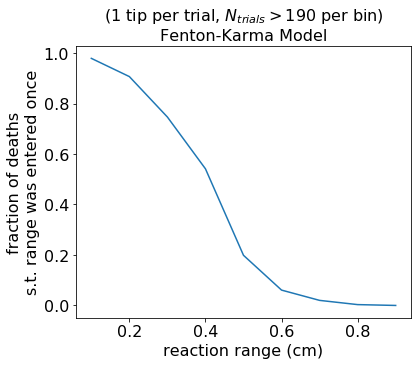

f(0.1)=0.9790575916230366


In [130]:
fig,ax=plt.subplots(figsize=(6,5))
# ax.plot(X_values,ferr_values)
ax.plot(X_values,favg_values)
ax.set_xlabel(r'reaction range (cm)',fontsize=fontsize)
ax.set_ylabel('fraction of deaths\ns.t. range was entered once',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize)
ax.set_title(u'(1 tip per trial, $N_{trials}>190$ per bin)\nFenton-Karma Model',fontsize=fontsize)
plt.show();print(f'f(0.1)={np.mean(df[(df.X==0.1)&(df.f>-1)].f.values)}')

In [131]:
# df=pd.read_csv('/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/rxn_range_results_ntips_10.csv')
df=pd.read_csv('/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/rxn_range_results_ntips_50.csv')
favg_values=np.array([np.mean(df[(df.X==X)&(df.f>-1)].f.values) for X in X_values])
ferr1_values=np.array([np.quantile(df[(df.X==X)&(df.f>-1)].f.values,0.25) for X in X_values])
ferr2_values=np.array([np.quantile(df[(df.X==X)&(df.f>-1)].f.values,0.75) for X in X_values])

N_values=np.array([len(list(set(df[(df.X==X)&(df.f>-1)].src.values))) for X in X_values])
N_values

array([141, 154, 156, 157, 157, 157, 157, 157, 157])

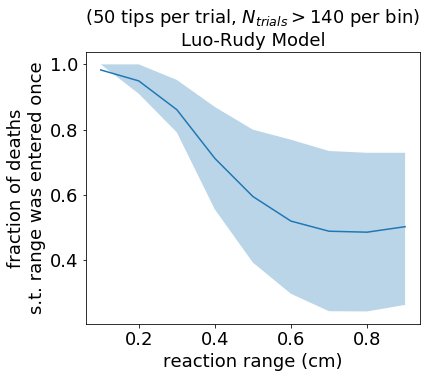

f(0.1)=0.9829009580689313


In [132]:

fontsize=18
fig,ax=plt.subplots(figsize=(6,5))
ax.plot(X_values,favg_values)
ax.fill_between(X_values,ferr1_values,ferr2_values,alpha=0.3)
ax.set_xlabel(r'reaction range (cm)',
              fontsize=fontsize)
ax.set_ylabel('fraction of deaths\ns.t. range was entered once',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize)
ax.set_title(u'(50 tips per trial, $N_{trials}>140$ per bin)\nLuo-Rudy Model',fontsize=fontsize)
plt.show();print(f'f(0.1)={np.mean(df[(df.X==0.1)&(df.f>-1)].f.values)}')

In [60]:
X=0.1
f_values=df[(df.X==0.1)&(df.f>-1)].f.values
# np.min(f_values)
f_values

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.9       , 1.        , 1.        , 0.83333333,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.66666667, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.875     ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.8       , 1.        , 1.        ,
       0.9       , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [128]:
np.mean(f_values)

0.9829009580689313

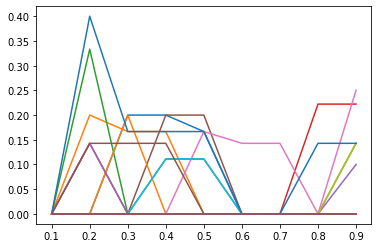

N_trials=36


In [1348]:
c=0
for src in df[(df.X==0.1)&(df.f==0.0)].src.values:
    d=df[df.src==src]
    x_values=np.array(d.X.values)
    y_values=np.array(d.f.values)
    plt.plot(x_values,y_values)
    c+=1
plt.show();print(f"N_trials={c}")

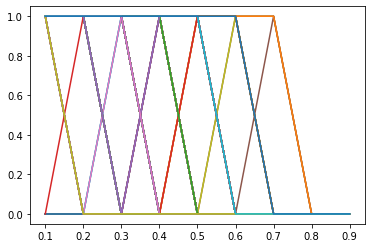

N_trials=191


In [28]:
c=0
for src in list(set(df[(df.X==0.1)&(df.f>=0.)].src.values)):
    d=df[df.src==src]
    x_values=np.array(d.X.values)
    y_values=np.array(d.f.values)
    plt.plot(x_values,y_values)
    c+=1
plt.show();print(f"N_trials={c}")

# estimate the mean number density 

In [ ]:

#LR
file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic001.21_traj_sr_600_mem_0.csv'
input_fn_lst = get_all_files_matching_pattern(file,trgt='_mem_0.csv')
print(len(input_fn_lst))

In [65]:
def routine2(file):
    df=pd.read_csv(file)
    return df.n.mean()/25 #per cm^2

# for fn in input_fn_lst:
#     #all CPU version
b = db.from_sequence(input_fn_lst, npartitions=9).map(routine2)
start = time.time()
qavg_lst = list(b)
print(f"run time: {time.time()-start:.2f} seconds.")
beep(10)

run time: 0.62 seconds.


0

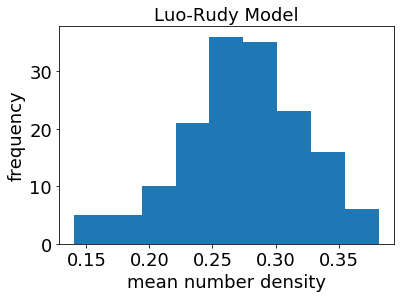

mean number density was 0.274 +- 0.049 tips per cm^2.
N_{trials}=157, A_{domain}=25 cm^2


In [82]:
plt.hist(qavg_lst,bins=9)
plt.xlabel('mean number density',fontsize=fontsize)
plt.ylabel('frequency',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize)
plt.title('Luo-Rudy Model',fontsize=fontsize)
plt.show()
print(f'mean number density was {np.mean(qavg_lst):.3f} +- {np.std(qavg_lst):.3f} tips per cm^2.')
print(f'N_{{trials}}={len(input_fn_lst)}, A_{{domain}}=25 cm^2')

In [83]:
#FK
file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.1_traj_sr_400_mem_0.csv'

#LR
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic001.21_traj_sr_600_mem_0.csv'
input_fn_lst = get_all_files_matching_pattern(file,trgt='_mem_0.csv')
print(len(input_fn_lst))

324


In [84]:
def routine2(file):
    df=pd.read_csv(file)
    return df.n.mean()/25 #per cm^2

# for fn in input_fn_lst:
#     #all CPU version
b = db.from_sequence(input_fn_lst, npartitions=9).map(routine2)
start = time.time()
qavg_lst = list(b)
print(f"run time: {time.time()-start:.2f} seconds.")
beep(10)

run time: 24.56 seconds.


0

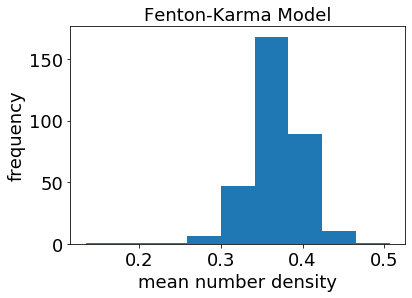

mean number density was 0.369 +- 0.035 tips per cm^2.
N_{trials}=324, A_{domain}=25 cm^2


In [86]:
plt.hist(qavg_lst,bins=9)
plt.xlabel('mean number density',fontsize=fontsize)
plt.ylabel('frequency',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize)
plt.title('Fenton-Karma Model',fontsize=fontsize)
plt.show()
print(f'mean number density was {np.mean(qavg_lst):.3f} +- {np.std(qavg_lst):.3f} tips per cm^2.')
print(f'N_{{trials}}={len(input_fn_lst)}, A_{{domain}}=25 cm^2')

# compute histogram of reaction ranges for given folder using daskbag

In [2]:
from lib.routines.return_reaction_ranges_from_folder import *

In [222]:
# def get_files_in_folder(folder,trgt):
#     '''gets all files in a given folder that contain a target string, trgt'''
#     os.chdir(folder)
#     fn_lst=os.listdir()
#     ifl=[]
#     for fn in fn_lst:
#         if fn.find(trgt)!=-1:
#             ifl.append(fn)
#     return ifl

# def return_bincounts_bdranges(folder,bin_edges,ds=5.,width=200.):
#     '''
#     Example Usage:
#     retval_lst=return_bincounts_bdranges(folder,bin_edges,ds=5.,width=200.)
#     beep(10)
#     '''

#     input_fn_lst=get_files_in_folder(folder,trgt='_traj_')
#     print(f"binning {len(input_fn_lst)} files...")

#     def routine(input_fn):
#         try:
#             bin_count_death, bin_count_birth,DT=comp_bdrange_bincounts(input_fn,bin_edges,ds=ds,width=width)
#             return bin_count_death, bin_count_birth, DT
#         except Exception as e:
#             return None

#     def agg(retval1,retval2):
#         val_lst=[]
#         for val1,val2 in zip(retval1,retval2):
#             val_lst.append(val1+val2)
#         retval=tuple(val_lst)
#         return retval

#     bag = db.from_sequence(input_fn_lst, npartitions=10).map(routine)
#     # retval_lst=list(bag)
#     # # took extra 16 minutes? slow... dask doesn't appear to cache like spark does...
#     # bag = db.from_sequence(retval_lst, npartitions=10).accumulate(agg)
#     # retval=list(bag)
#     # #DONE: instead, use agg to use retval_lst as input

#     start = time.time()
#     retval_lst = list(bag)
#     print(f"the run time for filtering files was {(time.time()-start)/60:.2f} minutes.")    
#     return retval_lst

In [9]:
file=search_for_file()

File: /Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/trajectories/tip_log_ds_5_sigma_1.0_threshold_0.8_006_traj_sr_50_mem_2.csv


In [11]:
file=f"/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/trajectories/tip_log_ds_5_sigma_1.0_threshold_0.8_006_traj_sr_50_mem_2.csv"
# file=f"/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ds_5_param_set_8/trajectories/ic_200x200.111.12_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_traj.csv"

In [12]:
#token LR trial
# file="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/trajectories/ic001.13_traj_sr_600_mem_0.csv"
# file="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic002.33_traj_sr_600_mem_0.csv"
#token FK trial
# file="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8_fastkernel_V_0.4/trajectories/ic_200x200.001.12_traj_sr_400_mem_2.csv"
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8_fastkernel_V_0.4/trajectories/ic_200x200.001.12_traj_sr_400_mem_2.csv'
input_fn=file
folder=os.path.dirname(file)
df=pd.read_csv(input_fn)
DT=compute_DT(df,round_t_to_n_digits=3)
trialname=os.path.basename(os.path.dirname(folder))
print(f"there was {DT} ms between observations for the trial run, {trialname}")

there was 0.7 ms between observations for the trial run, ds_5_param_set_8


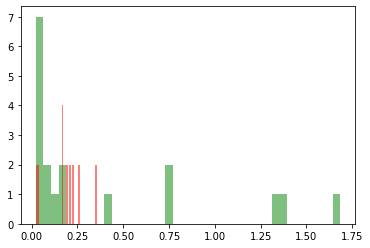

In [13]:
DS=5./200.
#compute interactions
df_interactions=compute_df_interactions(input_fn,DS=DS)
# df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

plt.hist(birth_ranges,color='green',alpha=0.5,bins=40)
plt.hist(death_ranges,color='red',alpha=0.5,bins=40)
plt.show()

In [14]:
# bin_edges=np.arange(0,10,0.005) #cm
bin_edges=np.arange(0,10,0.05) #cm

# bin_edges=get_bin_edges(input_fn,ds=5.,width=200.,nbins=40)
# print(f"maximum bin edges is {np.max(bin_edges):.2f} cm.")
bin_edges.shape

(200,)

In [277]:
retval_lst=return_bincounts_bdranges(folder,bin_edges,ds=5.,width=200.)
beep(10)

binning 159 files...
the run time for filtering files was 14.10 minutes.


0

In [280]:
#DONE: showed runtime was roughly independent of bin number
# 35.8 #minutes runtime for 40 bins, same for 2000 bins... 2000 bins used for now on

In [281]:
#post processing
trial_count=len(retval_lst)
retval = retval_lst[0]
count=1
net_bin_count_death, net_bin_count_birth, DT=retval
for retval in retval_lst[1:]:
    bin_count_death, bin_count_birth, DT_local=retval
    if DT==DT_local:
        net_bin_count_death+=bin_count_death
        net_bin_count_birth+=bin_count_birth   
        count+=1

assert (count==trial_count)
range_values,brate_values,drate_values=comp_bdrates_by_bin(net_bin_count_birth,net_bin_count_death,bin_edges,DT)

In [282]:
print(f"{sum(net_bin_count_death)} spiral tip birth/death events were considered.")


742330 spiral tip birth/death events were considered.


In [283]:
#save as .csv in a centralized location with a reasonable name that can be loaded later
df=pd.DataFrame({
    'r':range_values,
    'brate':brate_values,
    'drate':drate_values
})

In [284]:
i=folder.find('Data')
data_folder=folder[:i+4]
tnl=folder[i+5:].split('/')[:2]
trialname=tnl[0]+'_'+tnl[1]
trialname=trialname.replace('_','-').lower()
save_fn=trialname+f'-nbins-{bin_edges.shape[0]-1}-DT-{DT:.2f}.csv'
save_fn

'initial-conditions-suite-3-lr-param-qu-tmax-30-ko-3.8-diffcoef-0.0005-nbins-199.csv'

In [285]:
save_foldername='reaction-ranges'
os.chdir(data_folder)
if not os.path.exists(save_foldername):
    os.mkdir(save_foldername)
save_folder=os.path.abspath(save_foldername)
os.chdir(save_foldername)


In [286]:
df.to_csv(save_fn,index=False)
print(f"reaction range results saved in {os.path.abspath(save_fn)}")

reaction range results saved in /home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-suite-3-lr-param-qu-tmax-30-ko-3.8-diffcoef-0.0005-nbins-199.csv


In [287]:
#TODO: print a 1 trial sample in Mathematica
#TODO: for a 1 trial sample in Mathematica, see what distribution might fit best.

In [288]:
# bin_count_death, bin_count_birth,DT=comp_bdrange_bincounts(input_fn,bin_edges,ds=5.,width=200.)
# range_values,brate_values,drate_values=comp_bdrates_by_bin(bin_count_birth,bin_count_death,bin_edges,DT)


In [263]:
# df=pd.read_csv(input_fn)
# DS=5./200.
# DT=compute_DT(df,round_t_to_n_digits=3);print(DT)
# #compute interactions
# df_interactions=compute_df_interactions(file,DS=DS)
# # df_interactions.dropna(inplace=True)
# death_ranges=DS*df_interactions.rT.values
# birth_ranges=DS*df_interactions.r0.values

2.0


In [290]:
!ls

initial-conditions-suite-2-ds-5-param-set-8-fastkernel-v-0.4.csv
initial-conditions-suite-2-ds-5-param-set-8-fastkernel-v-0.4-nbins-40.csv
initial-conditions-suite-3-lr-param-qu-tmax-30-ko-3.8-diffcoef-0.0005.csv
initial-conditions-suite-3-lr-param-qu-tmax-30-ko-3.8-diffcoef-0.0005-nbins-199.csv
initial-conditions-suite-3-lr-param-qu-tmax-30-ko-3.8-diffcoef-0.001-nbins-199.csv
initial-conditions-suite-3-lr-param-qu-tmax-30-ko-3.8-diffcoef-0.001-nbins-2000.csv


In [289]:
# list(birth_ranges)
os.chdir(save_folder)
df=pd.read_csv(save_fn)
df.head()
range_values=df.r.values
brate_values=df.brate.values
drate_values=df.drate.values

fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))
# ax.set_xlim([0,0.5])
ax.set_xlim([0,2.])
# ax.set_ylim([0,800])
# ax.set_yscale('log')
print(save_fn)

NameError: name 'total_count' is not defined

In [214]:
#for naive sample from the FK model, the extreme value distribution
birth_location=0.18335122955448724#cm
birth_scale=0.1316063323393546#cm
alpha=birth_location
beta=birth_scale

def comp_extreme_value_pdf(x,alpha,beta):
    val=(alpha-x)/beta
    p=np.exp(val-np.exp(val))/beta
    return p

#compare to the functional form of the gumbel distribution
def comp_gumbel_pdf(x,alpha,beta):
    val=-(alpha-x)/beta
    p=np.exp(val-np.exp(val))/beta
    return p


birth_hat_values=comp_extreme_value_pdf(range_values,alpha,beta)
plt.plot(range_values,birth_hat_values)
plt.show()

In [391]:
def run_reaction_ranges_routine(folder_in):
    input_fn_lst_pre=get_files_in_folder(folder_in,trgt='_traj_sr')
    input_fn_lst=[]
    for input_fn in input_fn_lst_pre:
        if input_fn.find('unwrap')==-1:
            input_fn_lst.append(input_fn)
    if len(input_fn_lst)==0:
        return False
    
    input_fn=input_fn_lst[0]

    #get width if specified for a given folder
    width=200.
    i=folder_in.find('00x')
    if i !=-1:
        s=folder_in[i+3:]
        width=float(eval(s.split('/')[0]))

    folder=folder_in # os.path.dirname(input_fn)
    df=pd.read_csv(input_fn)
    DT=compute_DT(df,round_t_to_n_digits=3)
    trialname=os.path.basename(os.path.dirname(folder))
    print(f"there was {DT} ms between observations for the trial run, {trialname}")

    bin_edges=np.arange(0,10.05,0.05) #cm

    retval_lst=return_bincounts_bdranges(folder,bin_edges,ds=5.,width=width)
    beep(2)

    #post processing
    trial_count=len(retval_lst)
    retval = retval_lst[0]
    count=1
    net_bin_count_death, net_bin_count_birth, DT=retval
    for retval in retval_lst[1:]:
        bin_count_death, bin_count_birth, DT_local=retval
        if DT==DT_local:
            net_bin_count_death+=bin_count_death
            net_bin_count_birth+=bin_count_birth
            count+=1

    assert (count==trial_count)
    range_values,brate_values,drate_values=comp_bdrates_by_bin(net_bin_count_birth,net_bin_count_death,bin_edges,DT)

    print(f"N={sum(net_bin_count_death)} spiral tip birth/death events were considered.")

    #save as .csv in a centralized location with a reasonable name that can be loaded later
    df=pd.DataFrame({
        'r':range_values,
        'brate':brate_values,
        'drate':drate_values
    })

    i=folder.find('Data')
    data_folder=folder[:i+4]
    tnl=folder[i+5:].split('/')[:2]
    trialname=tnl[0]+'_'+tnl[1]
    trialname=trialname.replace('_','-').lower()
    save_fn=trialname+f'-nbins-{bin_edges.shape[0]-1}-DT-{DT:.2f}.csv'

    save_foldername='reaction-ranges'
    os.chdir(data_folder)
    if not os.path.exists(save_foldername):
        os.mkdir(save_foldername)
    save_folder=os.path.abspath(save_foldername)
    os.chdir(save_foldername)

    # bin_count_death, bin_count_birth,DT=comp_bdrange_bincounts(input_fn,bin_edges,ds=5.,width=width)
    # range_values,brate_values,drate_values=comp_bdrates_by_bin(bin_count_birth,bin_count_death,bin_edges,DT)

    df.to_csv(save_fn,index=False)
    print(f"reaction range results saved in {os.path.abspath(save_fn)}")
    return True

initial-conditions-lr-300x300-param-qu-tmax-30-nbins-200.csv


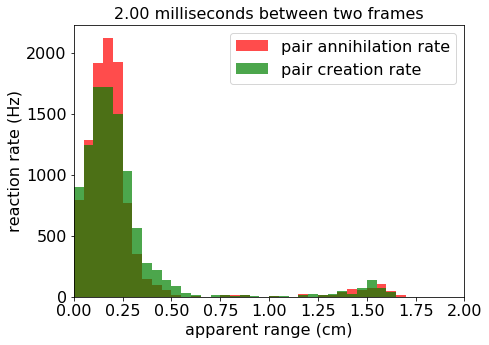

In [307]:
fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))
# ax.set_xlim([0,0.5])
ax.set_xlim([0,2.])
# ax.set_ylim([0,800])
# ax.set_yscale('log')
print(save_fn)
# plt.close()

# run range computation for all trial folders

In [363]:
from lib.routines.return_reaction_ranges_from_folder import *

In [364]:
#DONE: test command line routine
#TODO: recursively find all folders  that contain '_traj_' files


In [365]:
# def directory_find(trgt, root='.'):
#     for path, dirs, files in os.walk(root):
#         return path

In [366]:
# folder_lst=directory_find(trgt='_traj_', root=f'{nb_dir}/Data')
# len(folder_lst)

In [383]:
def get_folders_directly_containing_trgt(rootdir,trgt):
    '''
    Example Usage:
    rootdir=f'{nb_dir}/Data'
    trgt='_traj_'
    folder_lst=get_folder_directly_containing_trgt(rootdir,trgt)
    '''
    folder_lst=[]
    for path, dirs, files in os.walk(rootdir):
        input_fn_lst=get_files_in_folder(path,trgt=trgt)
        if len(input_fn_lst)>0:
            folder_lst.append(path)
    return folder_lst

In [385]:
rootdir=f'{nb_dir}/Data'
trgt='_traj_sr'
folder_lst=get_folders_directly_containing_trgt(rootdir,trgt)

In [386]:
len(folder_lst)

52

In [392]:
folder_
for folder in folder_lst:
    run_reaction_ranges_routine(folder)
    print('')

there was 2.0 ms between observations for the trial run, param_qu_tmax_30_Ko_3.8_diffCoef_0.00075
binning 159 files...
the run time for filtering files was 2.19 minutes.
N=63598 spiral tip birth/death events were considered.
reaction range results saved in /home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-suite-3-lr-param-qu-tmax-30-ko-3.8-diffcoef-0.00075-nbins-200-DT-2.00.csv


there was 2.0 ms between observations for the trial run, ds_5_param_qu_tmax_30_Ko_7.0_diffCoef_0.001
binning 46 files...
the run time for filtering files was 0.11 minutes.
N=3019 spiral tip birth/death events were considered.
reaction range results saved in /home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-suite-3-lr-ds-5-param-qu-tmax-30-ko-7.0-diffcoef-0.001-nbins-200-DT-2.00.csv


there was 2.0 ms between observations for the trial run, ds_5_param_qu_tmax_1
binning 318 files...
the run time for filtering files was 0.64 minutes

N=244955 spiral tip birth/death events were considered.
reaction range results saved in /home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-suite-2-ds-5-param-set-8-fastkernel-v-0.6-nbins-200-DT-1.00.csv

there was 1.0 ms between observations for the trial run, ds_5_param_set_8_fastkernel_V_0.6
binning 171 files...
the run time for filtering files was 22.58 minutes.
N=220529 spiral tip birth/death events were considered.
reaction range results saved in /home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-suite-2-ds-5-param-set-8-fastkernel-v-0.6-nbins-200-DT-1.00.csv

there was 1.0 ms between observations for the trial run, ds_5_param_set_8_lewiner_V_0.4_archive
binning 55 files...
the run time for filtering files was 2.07 minutes.
N=30722 spiral tip birth/death events were considered.
reaction range results saved in /home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-sui

TypeError: cannot unpack non-iterable NoneType object

In [401]:
#exclude the trial that raised a TypeError for non-iterable NoneType object...
n_found=-9999
for n,folder in enumerate(folder_lst):
    j=folder.find('600x600')
    if j!=-1:
        n_found=n
        j_found=j
n_found

43

In [403]:
folder_lst_neu=folder_lst[n_found+2:]
for folder in folder_lst_neu:
    run_reaction_ranges_routine(folder)
    print('')

there was 2.0 ms between observations for the trial run, param_qu_tmax_30
binning 2 files...
the run time for filtering files was 0.20 minutes.
N=1609 spiral tip birth/death events were considered.
reaction range results saved in /home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-lr-300x300-param-qu-tmax-30-nbins-200-DT-2.00.csv

there was 2.0 ms between observations for the trial run, param_qu_tmax_30
binning 288 files...
the run time for filtering files was 7.29 minutes.
N=197158 spiral tip birth/death events were considered.
reaction range results saved in /home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-lr-300x300-param-qu-tmax-30-nbins-200-DT-2.00.csv

there was 0.4 ms between observations for the trial run, param_set_8_ds_5.0_tmax_10_diffcoef_0.001
binning 648 files...
the run time for filtering files was 1.46 minutes.
N=30967 spiral tip birth/death events were considered.
reaction range results sav

/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges
200
/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-fk-200x200-param-set-8-ds-5.0-tmax-10-diffcoef-0.0005-nbins-200-DT-0.40.csv


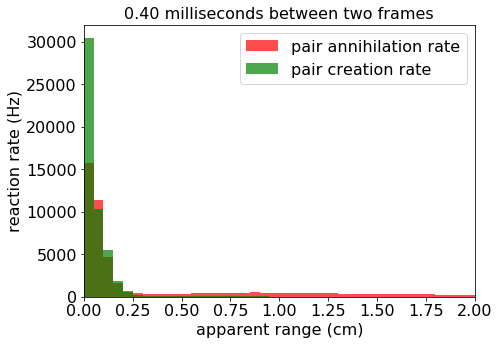

In [417]:
print(save_folder)
file=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-fk-200x200-param-set-8-ds-5.0-tmax-10-diffcoef-0.0005-nbins-200-DT-0.40.csv"
file=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-fk-200x200-param-set-8-ds-5.0-tmax-10-diffcoef-0.0005-nbins-200-DT-0.40.csv"
DT=0.4

# list(birth_ranges)
os.chdir(save_folder)
df=pd.read_csv(file)
print(df.r.values.shape[0])
range_values=df.r.values
brate_values=df.brate.values
drate_values=df.drate.values

fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))
# ax.set_xlim([0,0.5])
ax.set_xlim([0,2.])
# ax.set_ylim([0,800])
# ax.set_yscale('log')
print(file)

/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges
200
/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-suite-3-lr-ds-5-param-qu-tmax-1-nbins-200-DT-2.00.csv


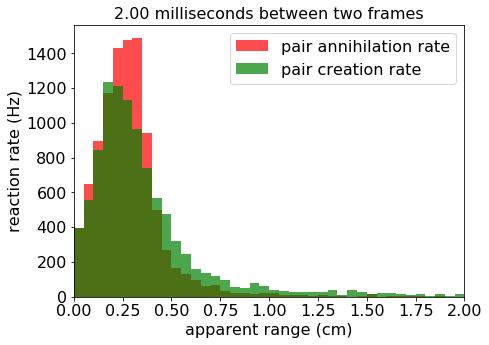

In [418]:
file="/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-suite-3-lr-ds-5-param-qu-tmax-1-nbins-200-DT-2.00.csv"
print(save_folder)
DT=2.0

os.chdir(save_folder)
df=pd.read_csv(file)
print(df.r.values.shape[0])
range_values=df.r.values
brate_values=df.brate.values
drate_values=df.drate.values

fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))
# ax.set_xlim([0,0.5])
ax.set_xlim([0,2.])
# ax.set_ylim([0,800])
# ax.set_yscale('log')
print(file)


In [419]:
os.chdir(save_folder)
!pwd

/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges


In [420]:
!ls

initial-conditions-fk-200x200-param-set-8-ds-5.0-tmax-10-diffcoef-0.0005-nbins-200-DT-0.40.csv
initial-conditions-fk-200x200-param-set-8-ds-5.0-tmax-10-diffcoef-0.001-nbins-200-DT-0.40.csv
initial-conditions-fk-300x300-ds-7.5-param-set-8-nbins-200-DT-1.00.csv
initial-conditions-lr-300x300-param-qu-tmax-30-nbins-200-DT-2.00.csv
initial-conditions-lr-600x600-param-qu-tmax-30-nbins-200-DT-2.00.csv
initial-conditions-suite-2-ds-10-param-set-8-og-nbins-200-DT-1.00.csv
initial-conditions-suite-2-ds-1-param-set-8-nbins-200-DT-0.40.csv
initial-conditions-suite-2-ds-2-param-set-8-nbins-200-DT-1.00.csv
initial-conditions-suite-2-ds-5-param-set-3-nbins-200-DT-1.00.csv
initial-conditions-suite-2-ds-5-param-set-4-nbins-200-DT-1.00.csv
initial-conditions-suite-2-ds-5-param-set-8-fastkernel-v-0.4.csv
initial-conditions-suite-2-ds-5-param-set-8-fastkernel-v-0.4-nbins-200-DT-1.00.csv
initial-conditions-suite-2-ds-5-param-set-8-fastkernel-v-0.4-nbins-40.csv
initial-conditions-suite-2-ds-5-param-set-8-fa

# TODO: use MLE on a visually reasonable sample of (i) the LR model 
and then,
- TODO: make .h header file for GEV reaction rates
- and (ii,later) the FK model

In [10]:
from scipy.stats import genextreme
from lib.routines.return_reaction_ranges_from_folder import PlotRangesBD

/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges
200
/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-suite-3-lr-ds-5-param-qu-tmax-1-nbins-200-DT-2.00.csv


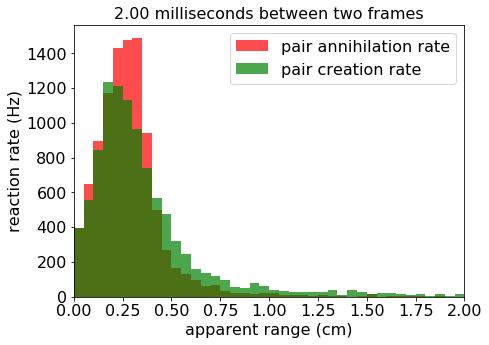

In [155]:
#TODO: load small data set for LR
file="/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-suite-3-lr-ds-5-param-qu-tmax-1-nbins-200-DT-2.00.csv"
save_folder=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges"
print(save_folder)
DT=2.0

os.chdir(save_folder)
df=pd.read_csv(file)
print(df.r.values.shape[0])
range_values=df.r.values
brate_values=df.brate.values
drate_values=df.drate.values

fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))
# ax.set_xlim([0,0.5])
ax.set_xlim([0,2.])
# ax.set_ylim([0,800])
# ax.set_yscale('log')
print(file)


In [157]:
#TODO: find if I can initialize genextreme.fit with reasonable values
genextreme.fit?

In [156]:
#fit distributions
dargs=genextreme.fit(drate_values)
bargs=genextreme.fit(brate_values)

dshape,dloc,dscale=genextreme.fit(-drate_values)
bshape,bloc,bscale=genextreme.fit(-brate_values)

print( bargs  , dargs)

#print the entropy of either fit
print( genextreme.entropy(*bargs)  , genextreme.entropy(*dargs))

(-1.037190718166508, 1.1062997345284547e-18, 2.3764225840050164e-18) (-1.0369492083031355, 4.3157825091766585e-19, 1.6294664515944478e-18)
-38.405037038068116 -38.78252005132722


In [140]:
def comp_stats(data):
    return np.mean(data),np.var(data),stats.kurtosis(data),stats.skew(data)

In [141]:
data=drate_values
mean, var, skew, kurt = comp_stats(data)
print(mean, var, skew, kurt)
# #compare to fits
# mean, var, skew, kurt = genextreme.stats(dargs[0],loc=dargs[1],scale=dargs[2], moments='mvsk')
mean, var, skew, kurt = genextreme.stats(*dargs, moments='mvsk')
print(mean, var, skew, kurt)

50.0 49913.88328676688 27.141696922369693 5.2015751120912395
-26.9426737084898 839.9810123539324 -2.2297116633659946 7.633021117937384


In [142]:
(x, c, loc=0, scale=1)

SyntaxError: invalid syntax (<ipython-input-142-ee9da3a90451>, line 1)

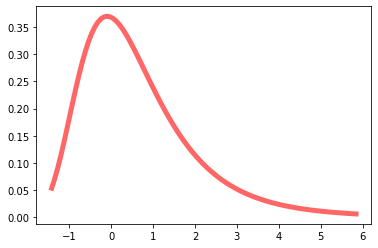

In [154]:
c = -0.1
mean, var, skew, kurt = genextreme.stats(c, moments='mvsk')

# Display the probability density function (``pdf``):

x = np.linspace(genextreme.ppf(0.01, c),
                 genextreme.ppf(0.99, c), 100)
plt.plot(x, genextreme.pdf(x, c),
        'r-', lw=5, alpha=0.6, label='genextreme pdf')
plt.show()

In [ ]:
# c = -0.1
c=bshape
mean, var, skew, kurt = genextreme.stats(c, moments='mvsk')

# Display the probability density function (``pdf``):

# x = np.linspace(genextreme.ppf(0.01, c),
#                  genextreme.ppf(0.99, c), 100)
x=x_values
y= genextreme.pdf(x, c,loc=bloc,scale=bscale)
plt.plot(x,y, 'r-', lw=5, alpha=0.6, label='genextreme pdf')
plt.show()


In [144]:
mean, var, skew, kurt

(array(0.68628702), array(2.22624107), array(1.91033913), array(7.97856624))

/home/timothytyree/Documents/GitHub/care/notebooks/Data/reaction-ranges/initial-conditions-suite-3-lr-ds-5-param-qu-tmax-1-nbins-200-DT-2.00.csv


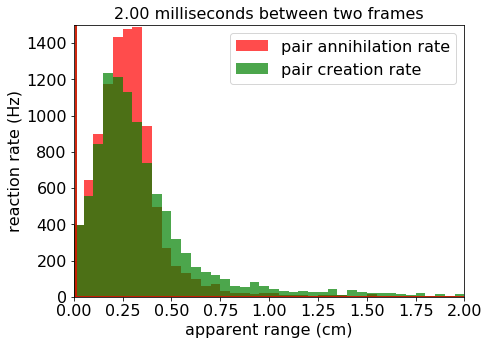

In [63]:
#evaluate the fits
x_values=np.arange(0,2.01,0.01)
yb_values=genextreme.pdf(x_values,*bargs)*500#/2*10**3
yd_values=genextreme.pdf(x_values,*dargs)*500#/2*10**3
# print(yd_values)

#plot the fits
fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))
ax.plot(x_values,yb_values,c='g')
ax.plot(x_values,yd_values,c='r')

# ax.set_xlim([0,0.5])
ax.set_xlim([0,2.])
ax.set_ylim([0,1500])
# ax.set_yscale('log')
print(file)


In [ ]:
#TODO: load large data set for LR

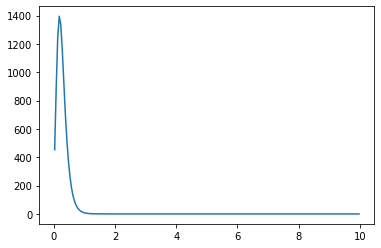

In [182]:
#for naive sample from the FK model, the extreme value distribution
birth_location=0.18335122955448724#cm
birth_scale=0.1316063323393546#cm
alpha=birth_location
beta=birth_scale

def comp_extreme_value_pdf(x,alpha,beta):
    val=(alpha-x)/beta
    p=np.exp(val-np.exp(val))/beta
    return p

#compare to the functional form of the gumbel distribution
def comp_gumbel_pdf(x,alpha,beta):
    val=-(alpha-x)/beta
    p=np.exp(val-np.exp(val))/beta
    return p

birth_hat_values=comp_extreme_value_pdf(range_values,alpha,beta)*500
plt.plot(range_values,birth_hat_values)
plt.show()

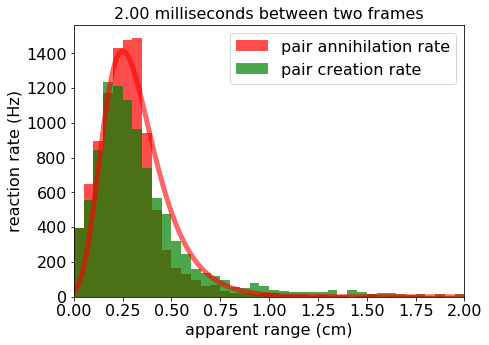

In [254]:
from scipy.stats import genextreme
import matplotlib.pyplot as plt

birth_location=0.18335122955448724#cm
birth_scale=0.1316063323393546#cm

death_location=0.25#8335122955448724#cm
death_scale=0.13#316063323393546#cm

# fig, ax = plt.subplots(1, 1)
# Calculate a few first moments:

fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))

# >>>
c =-.0
# mean, var, skew, kurt = genextreme.stats(c, moments='mvsk')
# Display the probability density function (pdf):

# >>>
x = x_values#np.linspace(genextreme.ppf(0.01, c),genextreme.ppf(0.99, c), 100)
# ax.plot(x, genextreme.pdf(x, c,loc=birth_location,scale=birth_scale)*500,
ax.plot(x, genextreme.pdf(x, c,loc=death_location,scale=death_scale)*500,
       'r-', lw=5, alpha=0.6, label='genextreme pdf')

ax.set_xlim([0,2])
plt.show()

In [207]:
# TODO: measure shape coefficient for death rate
# TODO: compute death_loc,scale

In [255]:
drate_values

array([3.94100880e+02, 6.46300657e+02, 8.98500434e+02, 1.17300781e+03,
       1.43202379e+03, 1.47787830e+03, 1.48903210e+03, 9.41876317e+02,
       4.97583344e+02, 2.70169786e+02, 1.67306977e+02, 1.28888338e+02,
       9.91448754e+01, 6.07262362e+01, 6.81621019e+01, 3.22220845e+01,
       2.29272524e+01, 1.98289751e+01, 1.73503532e+01, 2.16879415e+01,
       1.98289751e+01, 9.91448754e+00, 9.91448754e+00, 8.67517660e+00,
       6.19655472e+00, 8.67517660e+00, 7.43586566e+00, 7.43586566e+00,
       0.00000000e+00, 2.47862189e+00, 1.36324204e+01, 0.00000000e+00,
       6.19655472e+00, 3.71793283e+00, 2.47862189e+00, 3.71793283e+00,
       1.23931094e+00, 6.19655472e+00, 1.23931094e+00, 0.00000000e+00,
       3.71793283e+00, 2.47862189e+00, 3.71793283e+00, 4.95724377e+00,
       0.00000000e+00, 1.23931094e+00, 1.23931094e+00, 0.00000000e+00,
       0.00000000e+00, 1.23931094e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.47862189e+00, 0.00000000e+00,
      

File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/trajectories/ic001.23_traj_sr_600_mem_0.csv


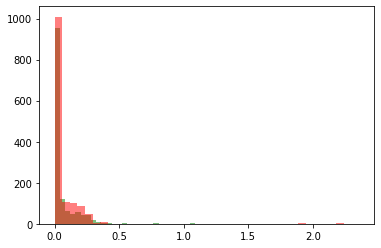

In [212]:
input_fn=search_for_file()
DS=5./200.
#compute interactions
df_interactions=compute_df_interactions(input_fn,DS=DS)
# df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

plt.hist(birth_ranges,color='green',alpha=0.5,bins=40)
plt.hist(death_ranges,color='red',alpha=0.5,bins=40)
plt.show()

File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_10/trajectories/ic001.21_traj_sr_400_mem_0.csv


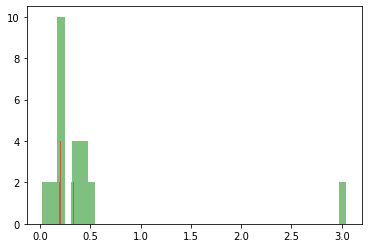

In [213]:
input_fn=search_for_file()
DS=5./200.
#compute interactions
df_interactions=compute_df_interactions(input_fn,DS=DS)
# df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

plt.hist(birth_ranges,color='green',alpha=0.5,bins=40)
plt.hist(death_ranges,color='red',alpha=0.5,bins=40)
plt.show()

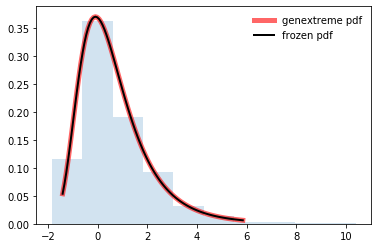

In [238]:
from scipy.stats import genextreme
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
# Calculate a few first moments:

# >>>
c = -0.1
mean, var, skew, kurt = genextreme.stats(c, moments='mvsk')
# Display the probability density function (pdf):

# >>>
x = np.linspace(genextreme.ppf(0.01, c),
                genextreme.ppf(0.99, c), 100)
ax.plot(x, genextreme.pdf(x, c),
       'r-', lw=5, alpha=0.6, label='genextreme pdf')
# Alternatively, the distribution object can be called (as a function) to fix the shape, location and scale parameters. This returns a “frozen” RV object holding the given parameters fixed.

# Freeze the distribution and display the frozen pdf:

# >>>
rv = genextreme(c)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

vals = genextreme.ppf([0.001, 0.5, 0.999], c)
np.allclose([0.001, 0.5, 0.999], genextreme.cdf(vals, c))


r = genextreme.rvs(c, size=1000)
# And compare the histogram:

ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()


# DONE: test rrate_gev.h before implementing it in c...

In [360]:
def comp_gen_extreme_value_pdf(x,shape,location,scale):
    shape=-1.*shape
    val=(x-location)/scale
    #compute t(x)
    if shape==0:
        t=np.exp(-val)
    else:
        t=(1.+shape*val)**(-1./shape)
    #compute pdf
    p=t**(shape+1.)*np.exp(-1*t)/scale
    return p

def comp_rrate_gev(x,shape,location,scale,rate0):
    return rate0*comp_gen_extreme_value_pdf(x,shape,location,scale)
    
# from inspect import getsource
# print(getsource(genextreme.pdf))

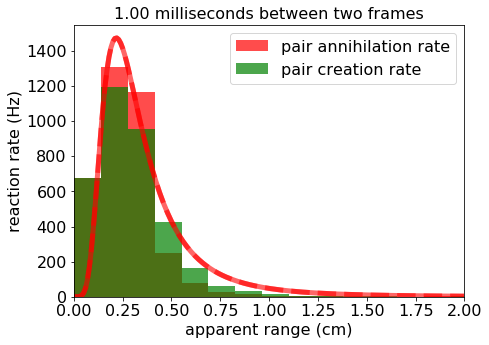

In [362]:
from scipy.stats import genextreme
import matplotlib.pyplot as plt

birth_location=0.18335122955448724#cm
birth_scale=0.1316063323393546#cm

death_location=0.25#8335122955448724#cm
death_scale=0.13#316063323393546#cm

# fig, ax = plt.subplots(1, 1)
# Calculate a few first moments:

fig,ax=PlotRangesBD(range_values,brate_values,drate_values,DT,fontsize=16,figsize=(7,5))

# >>>
c =-.3
# mean, var, skew, kurt = genextreme.stats(c, moments='mvsk')
# Display the probability density function (pdf):

# >>>
x = x_values#np.linspace(genextreme.ppf(0.01, c),genextreme.ppf(0.99, c), 100)
# ax.plot(x, genextreme.pdf(x, c,loc=birth_location,scale=birth_scale)*500,
ax.plot(x, genextreme.pdf(x, c,loc=death_location,scale=death_scale)*500,
       'r-', lw=5, alpha=0.6, label='genextreme pdf')

y=comp_rrate_gev(x,shape=c,location=death_location,scale=death_scale,rate0=500.)
ax.plot(x, y,
       'r--', lw=5, alpha=0.6, label='rrate_gev test')

ax.set_xlim([0,2])
plt.show()